In [1]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# Some functions for plotting. You don't have to understand how any
# of the functions in this cell work, since they use things we 
# haven't learned about in STOR 120

def make_correlated_data(r):
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    return x, y
    
def r_table(r):
    """
    Generate a table of 1000 data points with a correlation approximately r
    """
    np.random.seed(8)
    x, y = make_correlated_data(r)
    return Table().with_columns('x', x, 'y', y)

### Function Defined in Class

In [3]:
def standard_units(x):
    """Converts an array x to standard units"""
    return (x - np.mean(x)) / np.std(x)

In [4]:
def correlation(t, x, y):
    x_su = standard_units(t.column(x))
    y_su = standard_units(t.column(y))
    return np.mean(x_su * y_su)

In [5]:
def slope(t, x, y):
    """t is a table; x and y are column labels"""
    r = correlation(t, x, y)
    slope_xy = r * np.std(t.column(y)) / np.std(t.column(x))
    return slope_xy

In [6]:
def intercept(t, x, y):
    """t is a table; x and y are column labels"""
    slope_xy = slope(t, x, y)
    intercept_xy = np.average(t.column(y) - slope_xy * np.average(t.column(x)))
    return intercept_xy

In [7]:
def fitted_values(table, x, y):
    """Return the height of the regression line at each x value."""
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

### Back to Another Example

In [8]:
another_example = r_table(-0.7)

ae_slope = slope(another_example, 'x', 'y')
ae_intercept = intercept(another_example, 'x', 'y')

ae_slope, ae_intercept

(-0.6981331994734772, 0.03134780339154797)

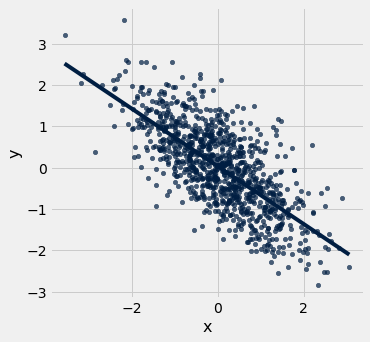

In [9]:
another_example.scatter('x', 'y', fit_line=True)

In [10]:
def another_example_rmse(any_slope, any_intercept):
    x = another_example.column('x')
    y = another_example.column('y')
    estimate = any_slope*x + any_intercept
    return (np.mean((y - estimate)**2)) ** 0.5

In [11]:
minimize(another_example_rmse)

array([-0.69813381,  0.03134782])

In [12]:
ae_slope, ae_intercept

(-0.6981331994734772, 0.03134780339154797)

### Residual Diagnostics: Residual Plots - Another Example

In [13]:
def residual(table, x, y):
    return table.column(y) - fitted_values(table, x, y)

def residual_plot(table, x, y):
    x_array = table.column(x)
    t = Table().with_columns(
            x, x_array,
            'residuals', residual(table, x, y)
        )
    t.scatter(x, 'residuals', color='r')
    xlims = make_array(min(x_array), max(x_array))
    plots.plot(xlims, make_array(0, 0), color='darkblue', lw=4)
    plots.title('Residual Plot')

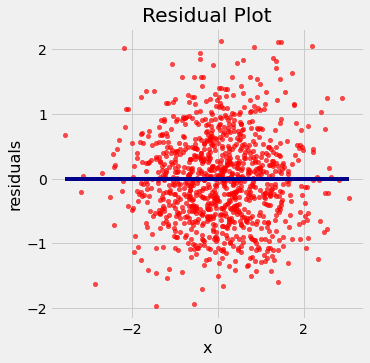

In [14]:
residual_plot(another_example, 'x', 'y')

In [15]:
another_example_with_resid = another_example.with_columns(
    'residual', residual(another_example, 'x', 'y'),
    'fit', fitted_values(another_example, 'x', 'y')
)

In [16]:
correlation(another_example_with_resid,'x', 'residual')

-1.5631940186722203e-16

In [17]:
correlation(another_example_with_resid,'fit', 'residual')

1.474376176702208e-16

In [18]:
np.mean(another_example_with_resid.column('residual'))

-1.7763568394002505e-17

### Residual Diagnostics: Residual Plots - Shotput

In [27]:
shotput = Table.read_table('../Datasets/shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


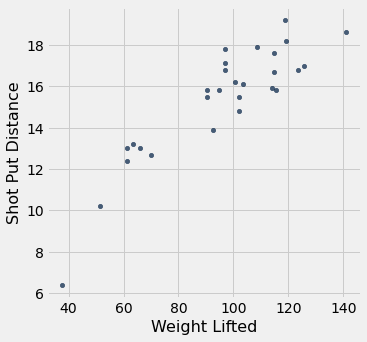

In [28]:
shotput.scatter('Weight Lifted')

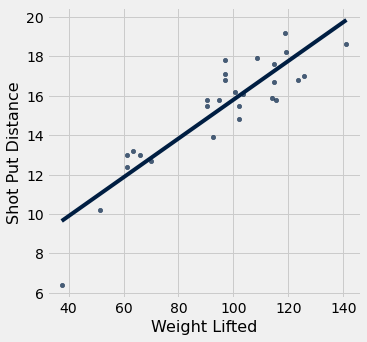

In [29]:
shotput.scatter('Weight Lifted', fit_line=True)

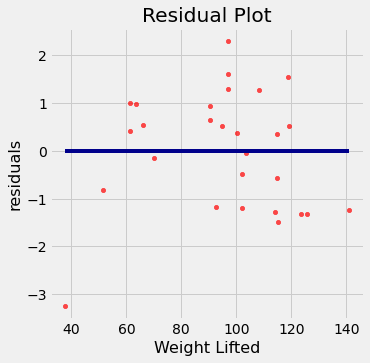

In [30]:
residual_plot(shotput, 'Weight Lifted', 'Shot Put Distance')

In [31]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [47]:
best_line = minimize(shotput_linear_rmse)
best_line

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


In [33]:
weights = shotput.column(0)

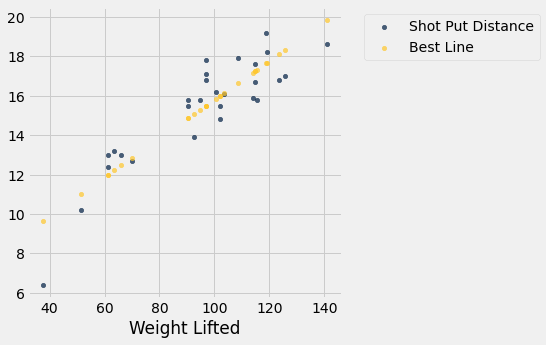

In [34]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

### Can we fix patterns in Residual Plots?

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [35]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [36]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([-1.04003731e-03,  2.82706003e-01, -1.53167618e+00])

In [37]:
# x = weight lifted = 100 kg
# Then predicted shot put distance:

(-0.00104)*(100**2) + 0.2827*100 - 1.5318

16.3382

In [38]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

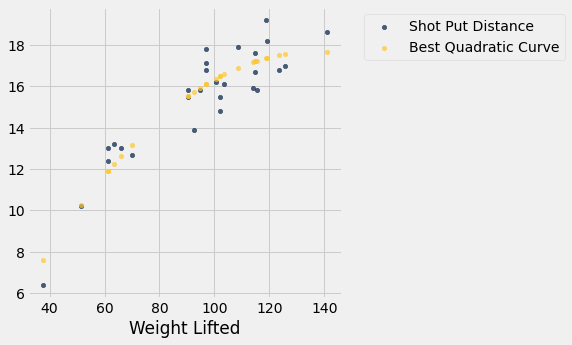

In [39]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)

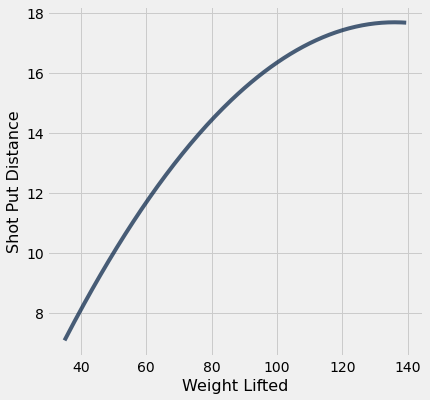

In [40]:
x = np.arange(35, 140, 0.5)
y = best_quad.item(0)*(x**2) + best_quad.item(1)*x + best_quad.item(2)

Table().with_columns('Weight Lifted', x, 'Shot Put Distance', y).plot('Weight Lifted')

### Residual Diagnostics: Heteroscedasticity (Uneven Spread)

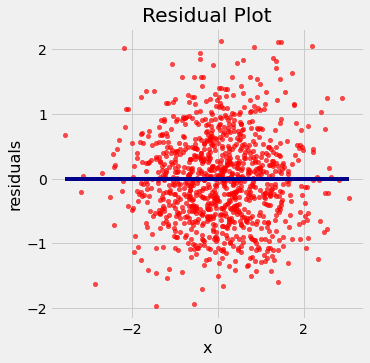

In [41]:
residual_plot(another_example, 'x', 'y')

In [44]:
hybrid = Table.read_table('../Datasets/hybrid.csv')
hybrid.show(5)

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact


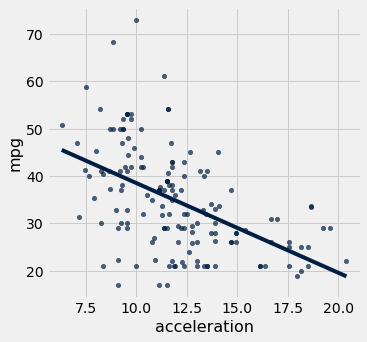

In [45]:
hybrid.scatter('acceleration', 'mpg', fit_line=True)

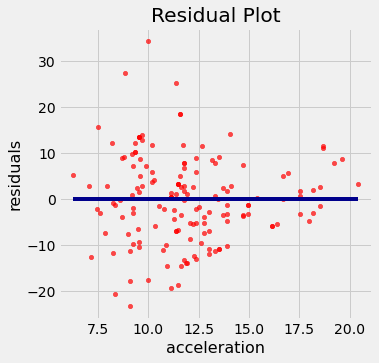

In [46]:
residual_plot(hybrid, 'acceleration', 'mpg')